In [3]:
from tinyai import *

In [4]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray_r'
# set back to defaul
# mpl.rcParams['image.cmap'] = 'viridis'

In [5]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)

A slightly larger model

In [6]:
from functools import partial
from torch import nn

def get_model():
    nfs = [8, 16, 32, 64, 128]
    act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
    bn = nn.BatchNorm2d

    layers = [conv(1, 8, stride=1, act=act_gr, norm=bn)]
    layers += [conv(nfs[i], nfs[i+1], act=act_gr, norm=bn) for i in range(len(nfs)-1)]
    layers += [conv(nfs[-1], 10, act=None, norm=None), nn.Flatten()]
    return nn.Sequential(*layers)


In [7]:
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from torch import optim

iw = partial(init_weights, leaky=0.1)

astats = ActivationStats(plot_first_epoch=False)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [metrics, astats]

def get_learner():
    set_seed(42)
    model = get_model().apply(iw)
    return Trainer(model, dls, loss_func=cross_entropy, lr=3e-3, cbs=cbs, opt_func=optim.AdamW)

TypeError: ActivationStats.__init__() got an unexpected keyword argument 'plot_first_epoch'

In [ ]:
learn = get_learner()
learn.summary()

/Users/tom/fun/tinyai/tinyai/nn/functional.py:9: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


Tot params: 110266; MFLOPS: 1.1


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(256, 1, 28, 28)|(256, 8, 28, 28)|96|0.1|
|Sequential|(256, 8, 28, 28)|(256, 16, 14, 14)|1200|0.2|
|Sequential|(256, 16, 14, 14)|(256, 32, 7, 7)|4704|0.2|
|Sequential|(256, 32, 7, 7)|(256, 64, 4, 4)|18624|0.3|
|Sequential|(256, 64, 4, 4)|(256, 128, 2, 2)|74112|0.3|
|Sequential|(256, 128, 2, 2)|(256, 10, 1, 1)|11530|0.0|
|Flatten|(256, 10, 1, 1)|(256, 10)|0|0.0|


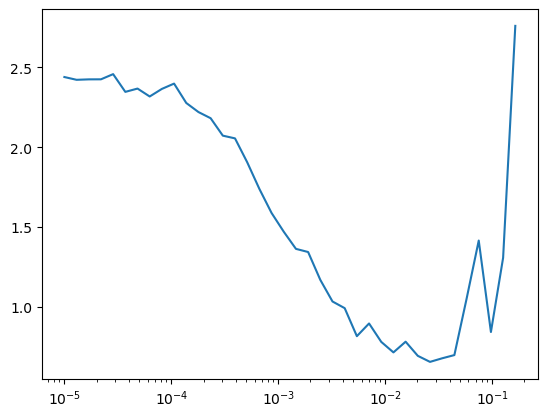

In [ ]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,0.4947,0.8254
0,eval,0.5436,0.8311
1,train,0.3714,0.8673
1,eval,0.4334,0.8456
2,train,0.2932,0.8939
2,eval,0.3317,0.8876
3,train,0.2274,0.9160
3,eval,0.2588,0.9091
4,train,0.1643,0.9395
4,eval,0.2367,0.9204


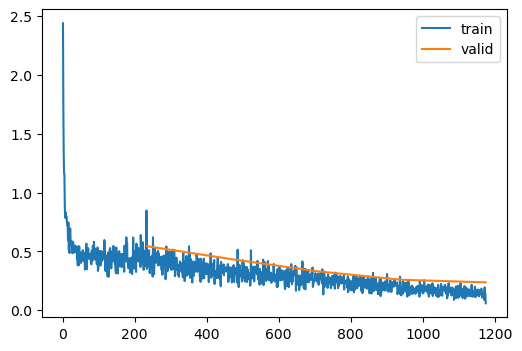

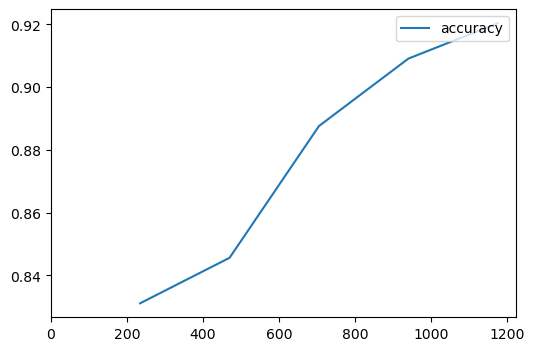

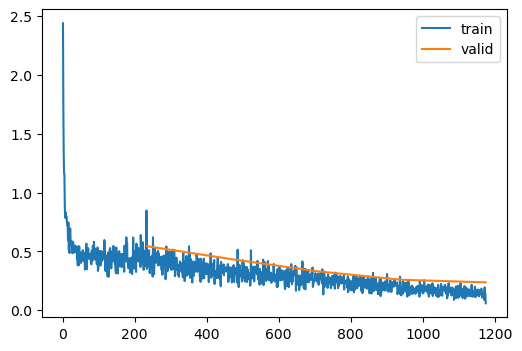

In [7]:
from torch.optim import lr_scheduler

nepochs = 5
tmax = len(dls.train) * nepochs
max_lr = 6e-2
sched = partial(lr_scheduler.OneCycleLR, max_lr=max_lr, total_steps=tmax)

learn.fit(nepochs, lr=3e-3, cbs=[BatchSchedCB(sched), PlotMetricsCB()])

epoch,train,loss,accuracy
0,train,0.1546,0.9438
0,eval,0.2452,0.9179
1,train,0.1358,0.9518
1,eval,0.2476,0.9202
2,train,0.1190,0.9582
2,eval,0.2524,0.9193
3,train,0.1050,0.9633
3,eval,0.2537,0.9214
4,train,0.0963,0.9670
4,eval,0.2541,0.9210


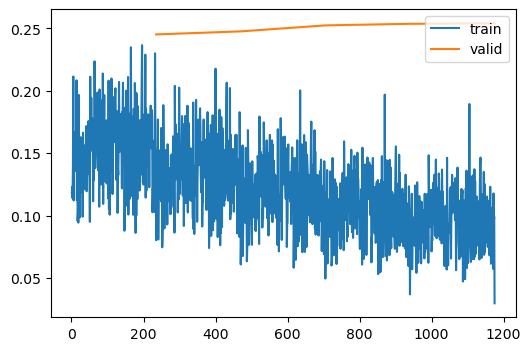

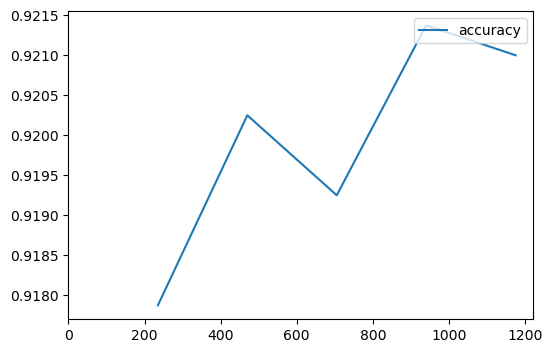

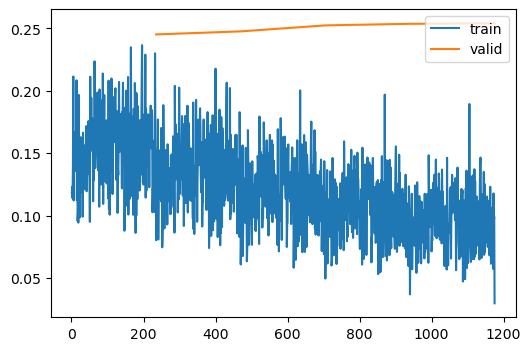

In [8]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)
learn.fit(nepochs, lr=3e-3, cbs=[BatchSchedCB(sched), PlotMetricsCB()])

In [9]:
from torch.nn import init
from typing import Any


def _conv_block(fi, fo, stride, ks=3, act=nn.ReLU, norm=nn.BatchNorm2d):
    c1 = conv(fi, fo, ks, stride=1, act=act, norm=norm)
    c2 = conv(fo, fo, ks, stride=stride, act=None, norm=norm)
    if norm:
        # setting bn mean to 0, will 0 the second layer
        nn.init.zeros_(c2[1].weight)  # type: ignore
    return nn.Sequential(c1, c2)


class ResBlock(nn.Module):
    def __init__(self, fi, fo, stride=1, ks=3, act: Any = nn.ReLU, norm=nn.BatchNorm2d):
        super().__init__()
        self.convs = _conv_block(fi, fo, stride, ks, act, norm)
        if stride == 1:
            self.id_conv = identity
            self.pool = identity
        elif stride == 2:
            self.id_conv = conv(fi, fo, stride=1, ks=1, act=None, norm=None)
            self.pool = nn.AvgPool2d(2, ceil_mode=True)
        else:
            raise ValueError("stride must be either 1 or 2, given:", stride)
        self.act = act()

    def forward(self, x):
        return self.act(self.convs(x) + self.id_conv(self.pool(x)))

In [10]:
from functools import partial
from torch import nn

def get_model():
    nfs = [8, 16, 32, 64, 128, 256]
    act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act_gr = nn.ReLU
    bn = nn.BatchNorm2d

    layers = [ResBlock(1, 8, stride=1, act=act_gr, norm=bn)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act_gr, norm=bn) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [8]:
learn = get_learner()
learn.summary()

/Users/tom/fun/tinyai/tinyai/nn/functional.py:9: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


Tot params: 1228892; MFLOPS: 4.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(256, 1, 28, 28)|(256, 8, 28, 28)|696|0.5|
|ResBlock|(256, 8, 28, 28)|(256, 16, 14, 14)|3696|0.7|
|ResBlock|(256, 16, 14, 14)|(256, 32, 7, 7)|14560|0.7|
|ResBlock|(256, 32, 7, 7)|(256, 64, 4, 4)|57792|0.9|
|ResBlock|(256, 64, 4, 4)|(256, 128, 2, 2)|230272|0.9|
|ResBlock|(256, 128, 2, 2)|(256, 256, 1, 1)|919296|0.9|
|Flatten|(256, 256, 1, 1)|(256, 256)|0|0.0|
|Linear|(256, 256)|(256, 10)|2560|0.0|
|BatchNorm1d|(256, 10)|(256, 10)|20|0.0|


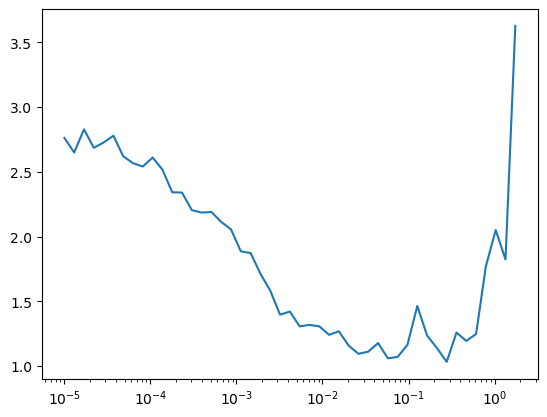

In [ ]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,0.6047,0.8121
0,eval,0.8602,0.7924
1,train,0.3573,0.8739
1,eval,0.6960,0.7649
2,train,0.2931,0.8952
2,eval,0.3398,0.8774
3,train,0.2347,0.9152
3,eval,0.2403,0.9134
4,train,0.1824,0.9349
4,eval,0.2158,0.9229


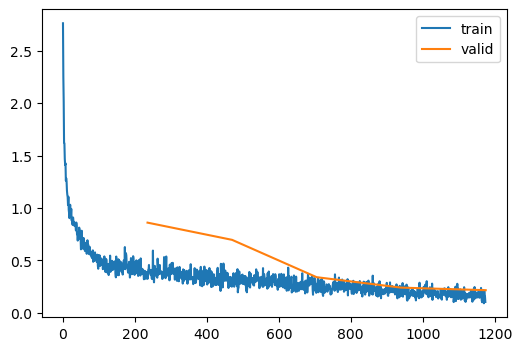

In [ ]:
learn.fit_one_cycle(5, 1e-1)

In [11]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        # inp: BCHW, mean over HW -> BC
        return x.mean((-1, -2))

def get_model():
    """Replaced first ResBlock with conv, so it dosen't have the 3 conv blocks
    Changed first layer to ks 5, stride 1 and -> 16 dim.
    """
    nfs = [16, 32, 64, 128, 256]
    act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
    bn = nn.BatchNorm2d

    layers = [conv(1, 16, stride=1, ks=5, act=act_gr, norm=bn)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act_gr, norm=bn) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [10]:
learn = get_learner()
learn.summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(256, 1, 28, 28)|(256, 16, 28, 28)|448|0.3|
|ResBlock|(256, 16, 28, 28)|(256, 32, 14, 14)|14560|2.8|
|ResBlock|(256, 32, 14, 14)|(256, 64, 7, 7)|57792|2.8|
|ResBlock|(256, 64, 7, 7)|(256, 128, 4, 4)|230272|3.7|
|ResBlock|(256, 128, 4, 4)|(256, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(256, 256, 2, 2)|(256, 256)|0|0.0|
|Linear|(256, 256)|(256, 10)|2560|0.0|
|BatchNorm1d|(256, 10)|(256, 10)|20|0.0|


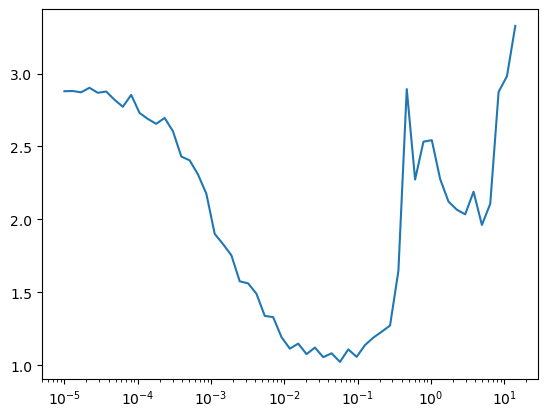

In [12]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,0.6142,0.8214
0,eval,1.3586,0.6302
1,train,0.3447,0.8783
1,eval,0.8285,0.7385
2,train,0.2856,0.8967
2,eval,0.4890,0.8251
3,train,0.2254,0.9189
3,eval,0.2630,0.9032
4,train,0.1694,0.9395
4,eval,0.2118,0.9230


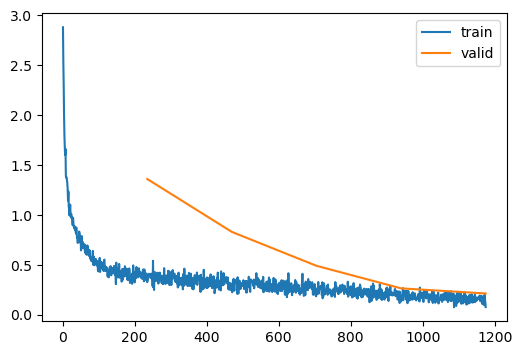

/Users/tom/fun/tinyai/tinyai/cbs.py:453: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tom/fun/tinyai/tinyai/cbs.py:470: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tom/fun/tinyai/tinyai/cbs.py:460: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


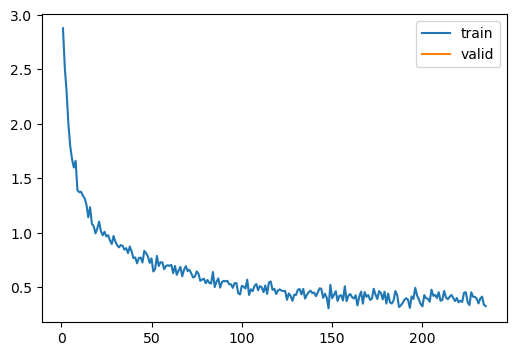

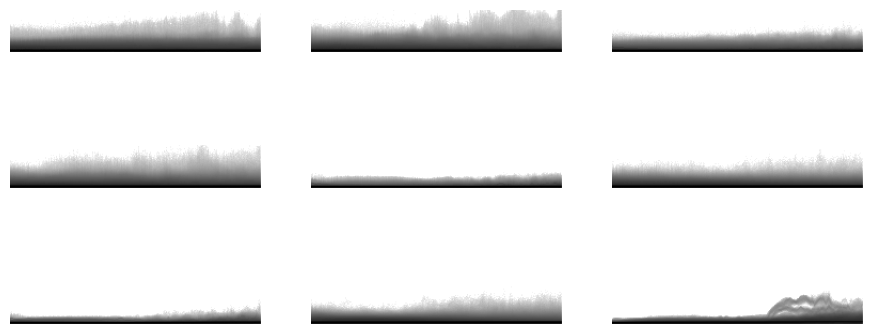

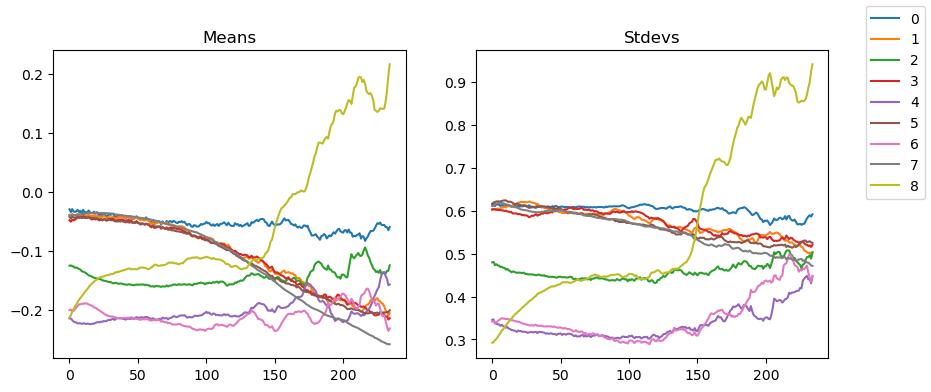

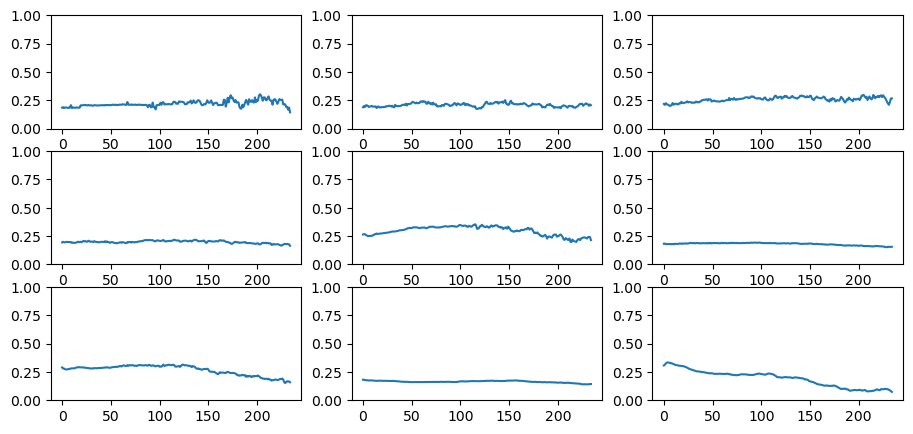

In [11]:
learn.fit_one_cycle(5, 5e-2)

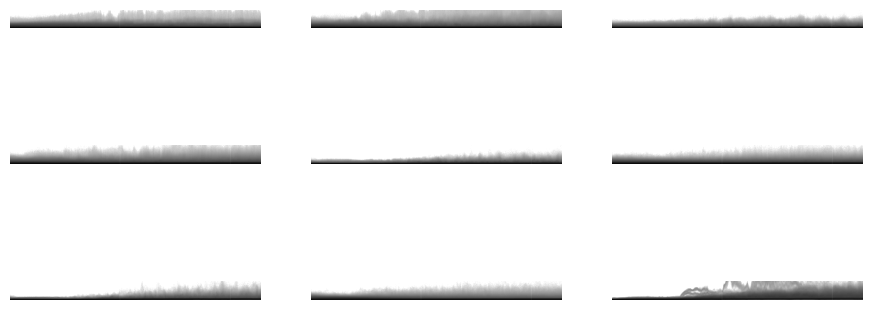

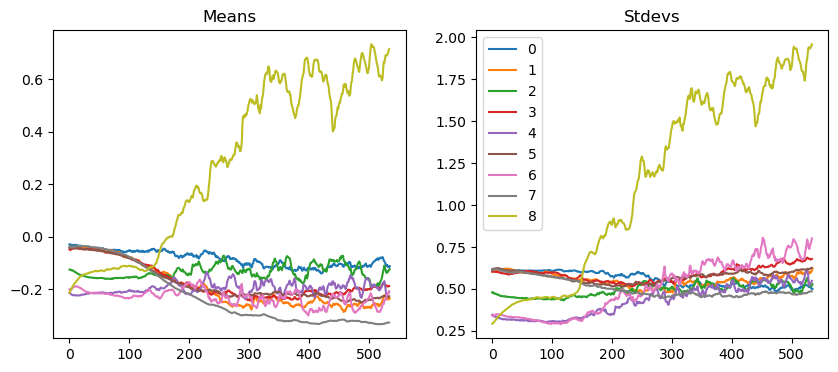

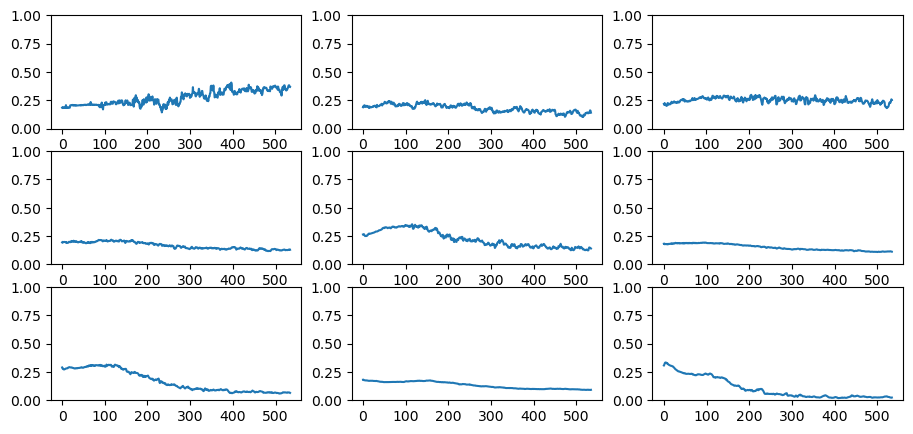

In [12]:
astats.plot_all()

## Data Augmentation

In [12]:
from torchvision import transforms

In [13]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=4), transforms.RandomHorizontalFlip())
def tfm_batch(b):
    xb, yb = b
    return tfms(xb), yb

augcb = BatchTransformCB(tfm_batch, val=False)

In [14]:
learn = get_learner()

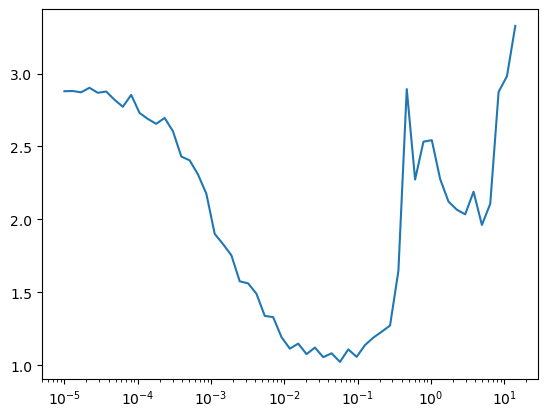

In [13]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,0.6927,0.7851
0,eval,1.3533,0.6277
1,train,0.4618,0.8356
1,eval,0.7619,0.7670
2,train,0.3523,0.8730
2,eval,0.3341,0.8824
3,train,0.2866,0.8957
3,eval,0.2513,0.9087
4,train,0.2319,0.9150
4,eval,0.2258,0.9193


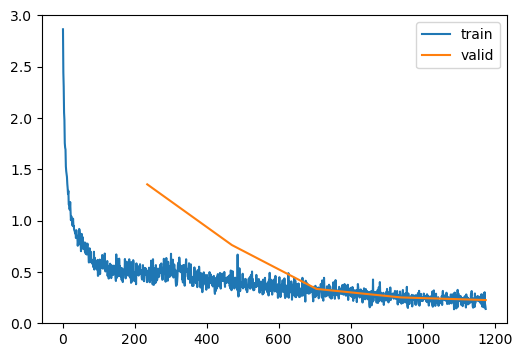

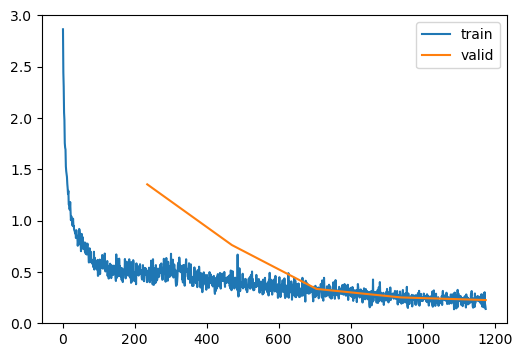

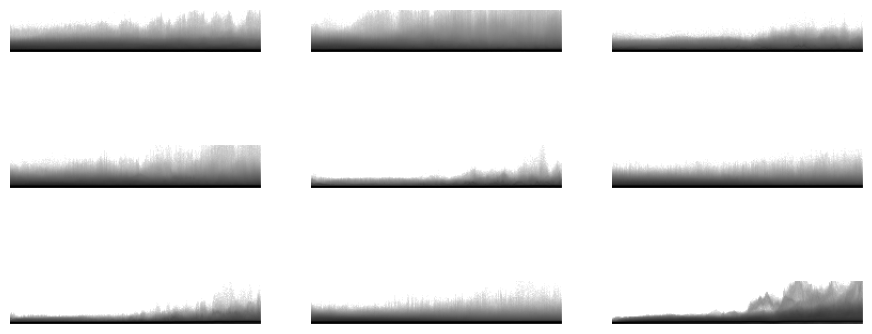

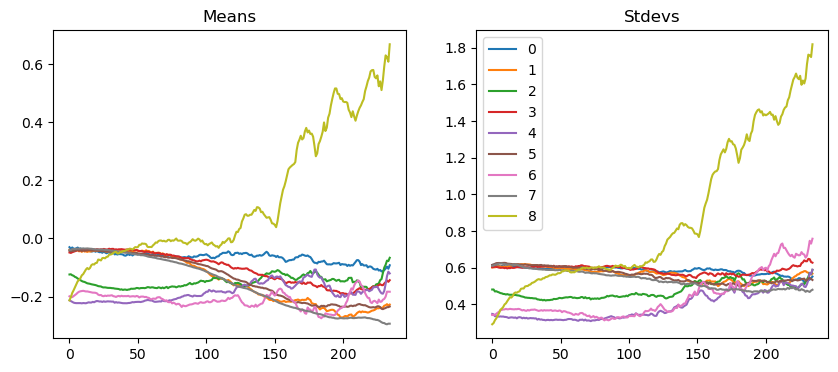

In [40]:
learn.fit_one_cycle(5, max_lr=8e-2, cbs=[augcb])

epoch,train,loss,accuracy
0,train,0.2000,0.9284
0,eval,0.2144,0.9220
1,train,0.1853,0.9332
1,eval,0.2088,0.9251
2,train,0.1734,0.9372
2,eval,0.2055,0.9277
3,train,0.1621,0.9420
3,eval,0.2045,0.9290
4,train,0.1508,0.9467
4,eval,0.2028,0.9299


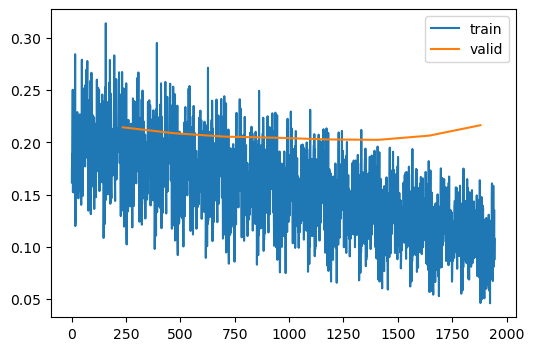

KeyboardInterrupt: 

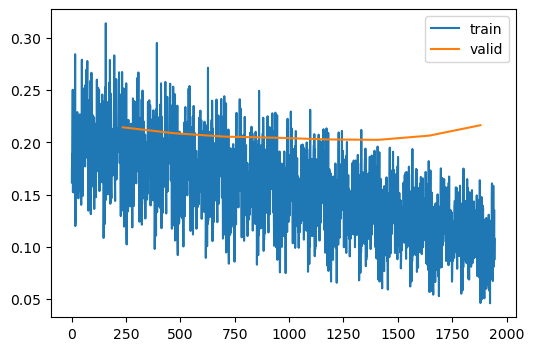

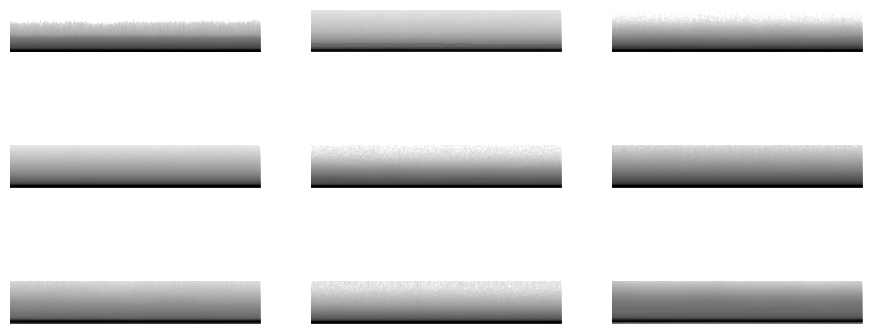

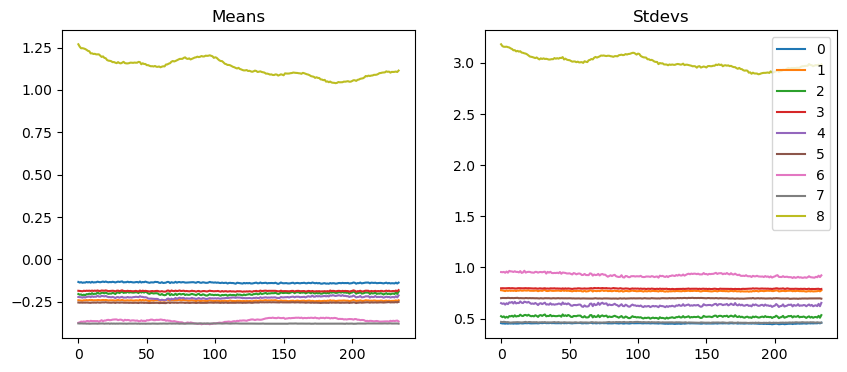

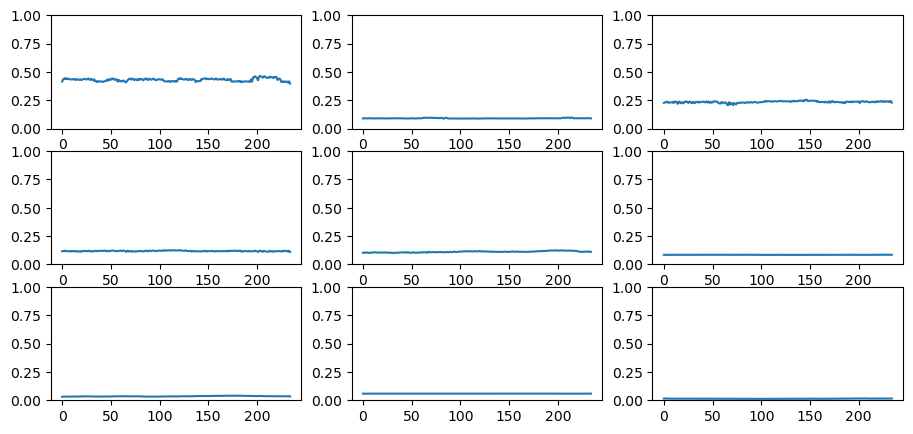

In [41]:
learn.fit(15, lr=2e-3)

## Random Erase

In [15]:
xb, yb = next(iter(dls.train))

In [19]:
import numpy as np
from torch.nn import init


def random_erase(x, pct=0.2, max_n=4):
    bmean, bstd, bmin, bmax = x.mean(), x.std(), x.min(), x.max()
    n = np.random.randint(0, max_n)
    for _ in range(n):
        _erase_block(x, pct, bmean, bstd, bmin, bmax)
    return x


def _erase_block(x, pct, bmean, bstd, bmin, bmax):
    # while the mean and std is correct, pixel values are not normally distributed
    # this can cause
    h, w = x.shape[-2], x.shape[-1]
    szx, szy = int(pct * h), int(pct * w)
    stx, sty = np.random.randint(0, h - szx), np.random.randint(0, w - szy)
    print(stx, sty)
    init.normal_(x[:, :, stx : stx + szx, sty : sty + szy], bmean, bstd)
    x.clamp_(bmin, bmax)


class RandomErase(nn.Module):
    def __init__(self, pct=0.2, max_n=4):
        super().__init__()
        self.pct = pct
        self.max_n = max_n
    
    def forward(self, x):
        return random_erase(x, self.pct, self.max_n)

20 0


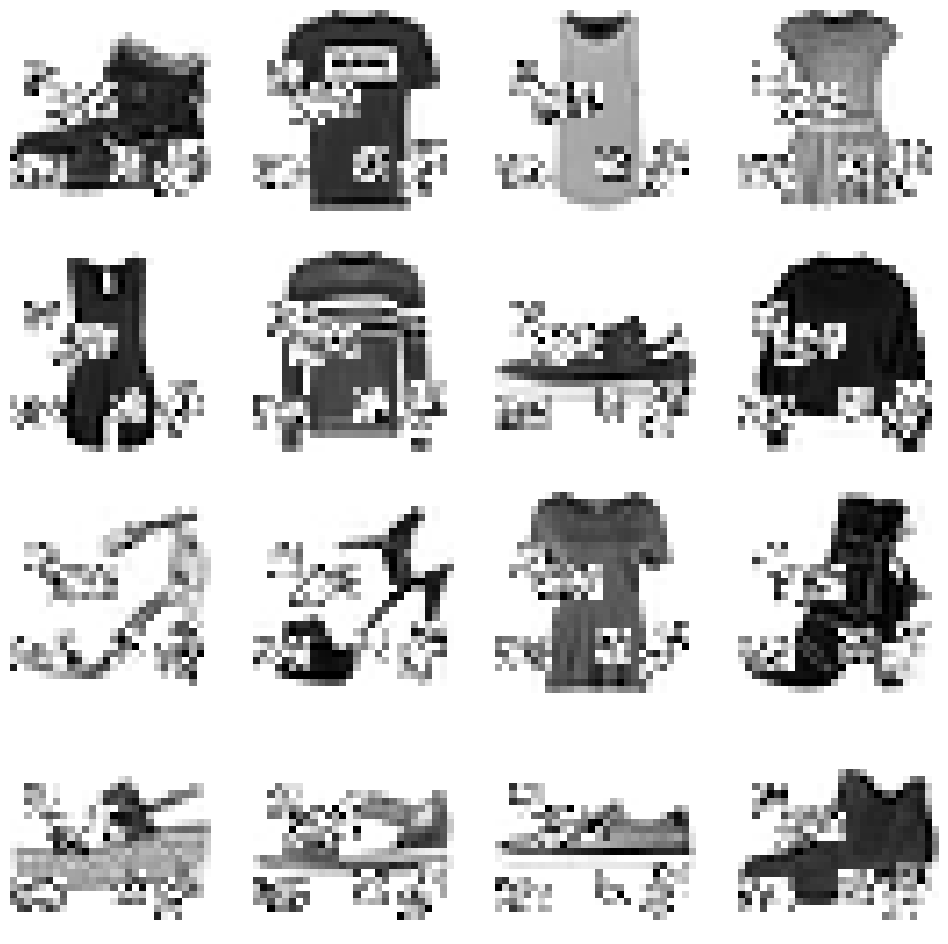

In [24]:
show_images(RandomErase()(xb[:16]))

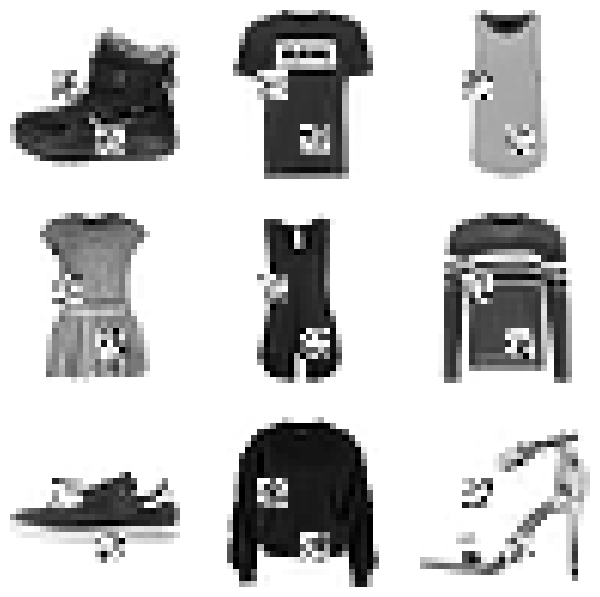

In [25]:
lim = 9
show_images(xb[:lim], imsize=2.5)

In [26]:
xb.mean(), xb.std()

(tensor(0.2806), tensor(0.3475))

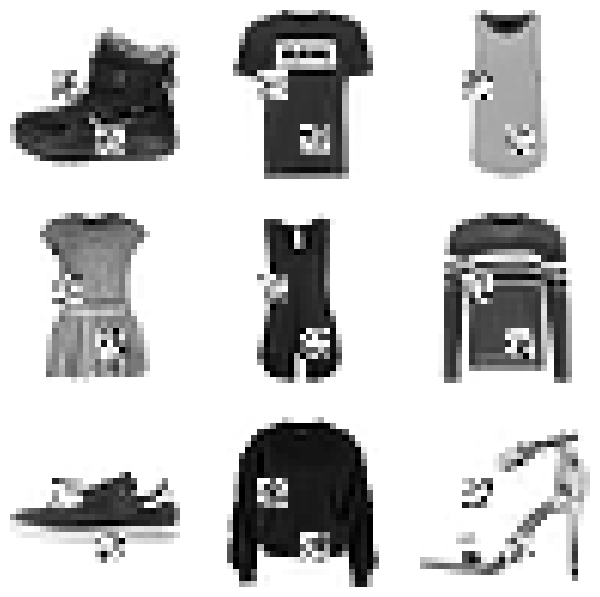

In [27]:
random_erase(xb)
show_images(xb[:lim], imsize=2.5,)

In [28]:
xb.mean(), xb.std()

(tensor(0.2806), tensor(0.3475))

In [74]:
from torchvision import transforms

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1), transforms.RandomHorizontalFlip(), RandomErase(0.2, max_n=20))

def tfm_batch(b):
    xb, yb = b
    return tfms(xb), yb

tfmcb = BatchTransformCB(tfm_batch, val=False)

2 6
5 7
8 4
0 18
9 11
14 21
8 19
16 16


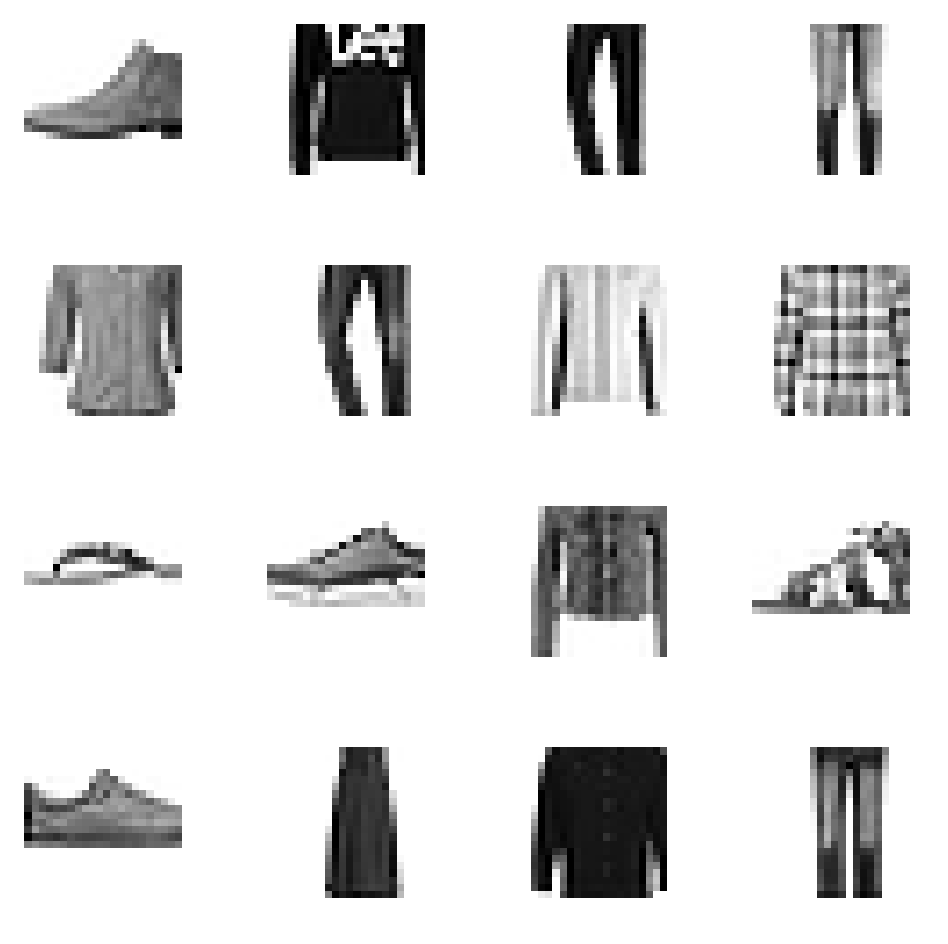

In [79]:
xb = tfms(xb)
show_images(xb[:16])

In [40]:
learn = get_learner()

19 14
10 7


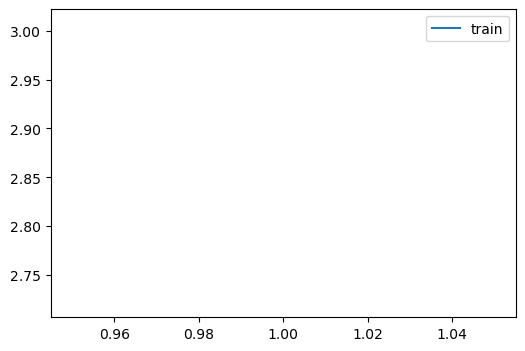

In [41]:
learn.fit(1, cbs=[NBatchCB(), tfmcb])

## Viz

In [25]:
xb, yb = learn.batch

i2s = tds['train'].features['label'].int2str
preds = i2s(learn.preds.argmax(1))
gt_y = i2s(yb)
titles = [f"{p}; {gt}" for p, gt in zip(preds, gt_y)]


lim = 9
show_images(xb[:lim], imsize=2.5, titles=titles[:lim])

AttributeError: batch